In [59]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
tensorboard.__version__

'2.4.0'

In [60]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [127]:
MicroclimateData = pd.read_csv('./Data/all_buildings_limited.csv')

In [128]:
#add extra features
MicroclimateData['Air Temp Squared'] =  MicroclimateData['Air Temp']**2
MicroclimateData['Abs Hum Squared'] =  MicroclimateData['Abs Hum']**2
MicroclimateData['Air Temp*Abs Hum'] =  MicroclimateData['Air Temp']* MicroclimateData['Abs Hum']
X = MicroclimateData[['bldgname',
              'Air Temp', 
              'Abs Hum',
              'Air Temp Squared',
              'Abs Hum Squared',
              'Air Temp*Abs Hum',
              'DSW Top', 
              'DSW North', 
              'DSW South', 
              'DSW East', 
              'DSW West', 
              'Shade North', 
              'Shade East', 
              'Shade West',
              'Shade South']]
columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
            'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
           'DSW North', 'DSW South', 'DSW East','DSW West',
           'Shade North', 'Shade East', 'Shade West', 'Shade South',]
Y = MicroclimateData['CHWTON/SQFT']
print(X)
print(Y.shape)
#scale values
Y = Y.values.reshape(-1, 1)
scaler = StandardScaler()        
Y = scaler.fit_transform(Y)
X = pd.get_dummies(X)
StdSc2 = StandardScaler()
X[columns] = StdSc2.fit_transform(X[columns])
print(X)
print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

           bldgname   Air Temp   Abs Hum  Air Temp Squared  Abs Hum Squared  \
0     Noble Library  23.516047  4.534450        553.004472        20.561234   
1     Noble Library  22.987733  5.423899        528.435871        29.418681   
2     Noble Library  22.796033  5.251924        519.659142        27.582705   
3     Noble Library  22.718680  5.220844        516.138404        27.257211   
4     Noble Library  22.609159  5.195012        511.174069        26.988152   
...             ...        ...       ...               ...              ...   
9584    Biodesign B  34.788404  7.628841       1210.233026        58.199217   
9585    Biodesign B  34.618771  7.730060       1198.459312        59.753827   
9586    Biodesign B  34.448187  7.886578       1186.677598        62.198117   
9587    Biodesign B  34.306344  7.940422       1176.925238        63.050304   
9588    Biodesign B  34.162529  7.993401       1167.078356        63.894454   

      Air Temp*Abs Hum    DSW Top  DSW North  DSW S

In [63]:
model = Sequential()
model.add(Dense(30, input_dim=25, kernel_initializer='he_normal',bias_initializer='he_normal',activation= 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation = 'linear'))
model.compile( loss = huber_loss, optimizer = 'adam')
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_13 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_14 (Dense)             (None, 40)                1640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 41        
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=200, 
                            verbose=0, 
                            validation_split=0.2)

In [14]:
def plot_curve():
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history.history["loss"],'r-x', label="Train Loss")
        ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
        ax.legend()
#         ax.set_title(text)
        ax.grid(True)    
#         save_name = "./Data/plots/" + text + ".png"
#         plt.savefig(save_name, bbox_inches='tight')

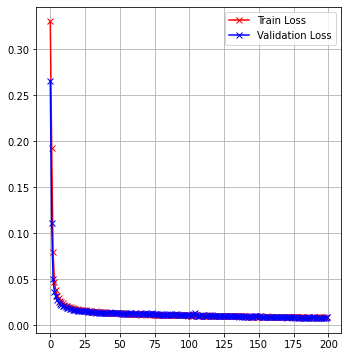

In [15]:
plot_curve()

In [129]:
#change dataset to reduce air temperature by 1
MicroclimateDataMod = pd.read_csv('./Data/all_buildings_limited.csv')
MicroclimateDataMod['Air Temp'] = MicroclimateDataMod['Air Temp'] - 1 #this is where we modify air temperature
MicroclimateDataMod['Air Temp Squared'] =  abs(MicroclimateDataMod['Air Temp']*MicroclimateDataMod['Air Temp'])
MicroclimateDataMod['Abs Hum Squared'] =  MicroclimateDataMod['Abs Hum']**2
MicroclimateDataMod['Air Temp*Abs Hum'] =  MicroclimateDataMod['Air Temp']* MicroclimateDataMod['Abs Hum']
X = MicroclimateDataMod[['bldgname',
              'Air Temp', 
              'Abs Hum',
              'Air Temp Squared',
              'Abs Hum Squared',
              'Air Temp*Abs Hum',
              'DSW Top', 
              'DSW North', 
              'DSW South', 
              'DSW East', 
              'DSW West', 
              'Shade North', 
              'Shade East', 
              'Shade West',
              'Shade South']]
columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
            'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
           'DSW North', 'DSW South', 'DSW East','DSW West',
           'Shade North', 'Shade East', 'Shade West', 'Shade South',]

scaler1 = StandardScaler() 
X = pd.get_dummies(X)
X[columns] = scaler1.fit_transform(X[columns])
print(X)

      Air Temp   Abs Hum  Air Temp Squared  Abs Hum Squared  Air Temp*Abs Hum  \
0    -2.465675 -0.819296         -2.197277        -0.718548         -1.217449   
1    -2.578016 -0.519787         -2.273392        -0.545618         -1.064054   
2    -2.618780 -0.577697         -2.300564        -0.581463         -1.106852   
3    -2.635228 -0.588163         -2.311461        -0.587818         -1.116517   
4    -2.658517 -0.596861         -2.326823        -0.593071         -1.126617   
...        ...       ...               ...              ...               ...   
9584 -0.068707  0.222697         -0.142620         0.016285          0.173973   
9585 -0.104778  0.256781         -0.179636         0.046636          0.192822   
9586 -0.141051  0.309486         -0.216673         0.094358          0.227831   
9587 -0.171213  0.327617         -0.247326         0.110996          0.233861   
9588 -0.201794  0.345457         -0.278272         0.127477          0.239358   

       DSW Top  DSW North  

      Air Temp   Abs Hum  Air Temp Squared  Abs Hum Squared  Air Temp*Abs Hum  \
3030  0.879263  2.701774          0.896545         3.267537          2.990988   
3037  1.302695  2.180776          1.400092         2.408609          2.694987   
3043  1.571375  1.834098          1.732527         1.888863          2.461603   
3069  1.067049  1.294769          1.116785         1.162565          1.644560   
3006 -0.137186  2.368277         -0.210520         2.706962          2.068654   
...        ...       ...               ...              ...               ...   
3016 -0.466276  2.803600         -0.538180         3.446328          2.250767   
3058  1.623779  1.429568          1.798536         1.334705          2.040557   
3028  0.732710  2.875526          0.728068         3.574772          3.074364   
3053  1.712007  1.550624          1.910530         1.494628          2.216398   
3045  1.632084  1.772623          1.809031         1.801017          2.424402   

       DSW Top  DSW North  

/home/biswas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:xlabel='Time'>

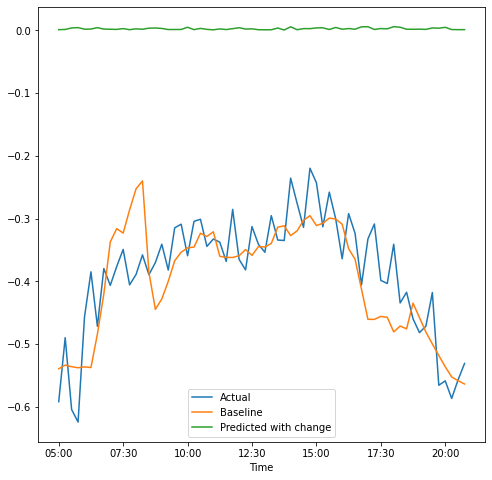

In [130]:
# plot predictions for baseline data data
date_time = MicroclimateData[['Date_Time',
                        'Month',
                        'Day',
                        'Hour',
                        'Minute']]
#for baseline results
comb1 = [X_train, X_test]
X_train = pd.concat(comb1)
Y_preds = model.predict(X_train)
y_train = np.concatenate((y_train, y_test))
results_NN = undummify(X_train).join(date_time)
results_NN['Actual'] = y_train
results_NN['Baseline'] = Y_preds

#for new data results
Y_preds_new = model.predict(X_new)
results_NN['Predicted with change'] = scaler.inverse_transform(Y_preds_new)

# find out for particular day
month_NN = results_NN[results_NN['Month'] == 8]
day_NN = month_NN[month_NN['Day'] == 1]
bldg_NN = day_NN.loc[day_NN['bldgname'] == "Schwada COB"]
bldg_NN['Time'] = bldg_NN['Date_Time'].str[11:16]  
print(bldg_NN)
values_NN = bldg_NN.sort_values(by=['Time'])

# #plot values_NN
ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
values_NN.plot(x='Time',y='Baseline',grid = False, figsize = (8,8),ax=ax)
values_NN.plot(x='Time',y='Predicted with change',grid = False, figsize = (8,8),ax=ax)
